### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Data

In [2]:
txt = open("data.txt","r")
txt = pd.DataFrame(txt)

In [3]:
df = pd.DataFrame()
df["Text"] = txt[0].transform(lambda x : x.split(";")[0])
df["Label"] = txt[0].transform(lambda x : x.split(";")[1][:-1])

In [4]:
print(df.shape)
df.head()

(16000, 2)


,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### Data Preprocessing

In [5]:
df["Label"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Label, dtype: int64

We will drop the surprise column as it is highly imbalanced

In [6]:
df = df[df["Label"] != "surprise"]

<AxesSubplot: xlabel='Label', ylabel='count'>

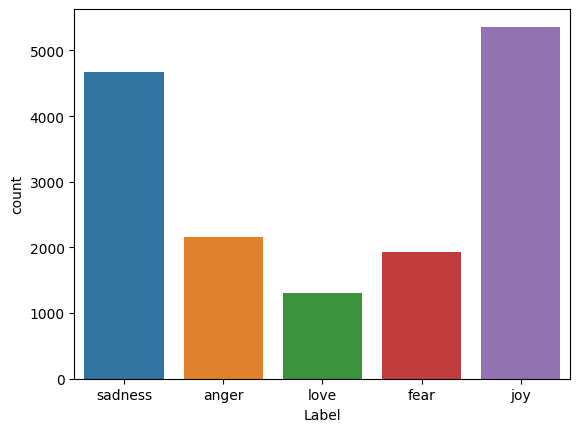

In [7]:
sns.countplot(x=df["Label"])

In [8]:
df.isnull().sum()

Text     0
Label    0
dtype: int64

In [9]:
# Removing Duplicate Value
print(df.duplicated().sum())
df = df.drop_duplicates()
df.reset_index(inplace=True,drop=True)

1


Checking if there are rows having the same text but different emotions 

In [10]:
print(df["Text"].duplicated().sum())
df[df["Text"].duplicated() == True].head()

23


,Text,Label
4864,i feel on the verge of tears from weariness i ...,joy
5883,i still feel a craving for sweet food,love
6295,i tend to stop breathing when i m feeling stre...,anger
7316,i was intensely conscious of how much cash i h...,sadness
7915,i am not amazing or great at photography but i...,love


In [11]:
df[df["Text"] == df.iloc[4864]["Text"]]

,Text,Label
1442,i feel on the verge of tears from weariness i ...,love
4864,i feel on the verge of tears from weariness i ...,joy


In [12]:
# Removing Duplicate Value
index = df[df["Text"].duplicated() == True].index
df.drop(index,axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [13]:
print("Shape :", df.shape)

Shape : (15404, 2)


### Text Preprocessing 

In [14]:
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [15]:
def text_preprocessing(text):
    
    # Remove punctuations and numbers
    text = re.sub("[^a-zA-Z]"," ",text.lower())
    text = re.sub(r"\s+",' ',text)
    
    # Tokenization
    token = word_tokenize(text)
    
    # Remove StopWords
    token = [i for i in token if i not in stopwords.words("english")]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(word) for word in token]
    
    processed_text = " ".join(token)
    return processed_text

In [16]:
df["Text"] = df["Text"].apply(lambda x : text_preprocessing(x))

### LabelEncoding 

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["Label"] = encoder.fit_transform(df["Label"])

In [18]:
# Save Encoder
import pickle

# saving
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
df.head()

,Text,Label
0,didnt feel humiliated,4
1,go feeling hopeless damned hopeful around some...,4
2,im grabbing minute post feel greedy wrong,0
3,ever feeling nostalgic fireplace know still pr...,3
4,feeling grouchy,0


## Train Test Split

In [20]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [21]:
y = pd.get_dummies(y)

In [22]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=69)

## Preparing Embedding Layer

In [23]:
from keras.preprocessing.text import Tokenizer,one_hot
from keras.utils import pad_sequences

In [24]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train["Text"])

x_train = word_tokenizer.texts_to_sequences(x_train["Text"])
x_test = word_tokenizer.texts_to_sequences(x_test["Text"])

In [25]:
# Save Tokenizer
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# Adding one to store dim for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
print(vocab_length)

11709


In [27]:
# Padding all the text

print("Maximum Length of the sentence in the corpus :", max([len(i) for i in x_train]))

max_len = 35

x_train = pad_sequences(x_train,padding="post",maxlen=max_len)
x_test = pad_sequences(x_test,padding="post",maxlen=max_len)

Maximum Length of the sentence in the corpus : 35


In [28]:
# Load GloVe Word Embeddings and Create Embedding Dict

embedding_dict = dict()
glove_file = open("a2_glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    data = line.split()
    word = data[0]
    vec = np.asarray(data[1:51],dtype="float32")
    embedding_dict[word] = vec
glove_file.close()

In [29]:
# Create Embedding Matrix having 50 Columns 

embedding_matrix = np.zeros((vocab_length,50))
for word,index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [30]:
embedding_matrix.shape

(11709, 50)

## Simple Neural Network 

In [31]:
import tensorflow as tf
from tensorflow import keras

In [32]:
model_nn = keras.Sequential(
           [keras.layers.Embedding(vocab_length,50,weights=[embedding_matrix],input_length=max_len,trainable=False),
            keras.layers.Flatten(),
            keras.layers.Dense(5,activation="softmax")
           ])

In [33]:
model_nn.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['acc'])

In [34]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 50)            585450    
                                                                 
 flatten (Flatten)           (None, 1750)              0         
                                                                 
 dense (Dense)               (None, 5)                 8755      
                                                                 
Total params: 594,205
Trainable params: 8,755
Non-trainable params: 585,450
_________________________________________________________________


In [35]:
# Training 

model_nn_history = model_nn.fit(x_train,y_train,batch_size=128,epochs=30,validation_split=0.2)

Epoch 1/30
78/78 [==============================] - 1s 4ms/step - loss: 1.4566 - acc: 0.3921 - val_loss: 1.3756 - val_acc: 0.4807
Epoch 2/30
78/78 [==============================] - 0s 2ms/step - loss: 1.3103 - acc: 0.4923 - val_loss: 1.3098 - val_acc: 0.4921
Epoch 3/30
78/78 [==============================] - 0s 2ms/step - loss: 1.2361 - acc: 0.5248 - val_loss: 1.2737 - val_acc: 0.5018
Epoch 4/30
78/78 [==============================] - 0s 2ms/step - loss: 1.1894 - acc: 0.5469 - val_loss: 1.2556 - val_acc: 0.5103
Epoch 5/30
78/78 [==============================] - 0s 2ms/step - loss: 1.1535 - acc: 0.5569 - val_loss: 1.2437 - val_acc: 0.5116
Epoch 6/30
78/78 [==============================] - 0s 2ms/step - loss: 1.1256 - acc: 0.5690 - val_loss: 1.2337 - val_acc: 0.5160
Epoch 7/30
78/78 [==============================] - 0s 2ms/step - loss: 1.1014 - acc: 0.5814 - val_loss: 1.2264 - val_acc: 0.5233
Epoch 8/30
78/78 [==============================] - 0s 2ms/step - loss: 1.0811 - acc: 0.59

In [36]:
# Evaluation on Test Set

score = model_nn.evaluate(x_test,y_test,verbose=1)

97/97 [==============================] - 0s 1ms/step - loss: 1.1940 - acc: 0.5501


In [37]:
print("Test Score :",score[0])
print("Test Accuracy :",score[1])

Test Score : 1.1940017938613892
Test Accuracy : 0.5501460433006287


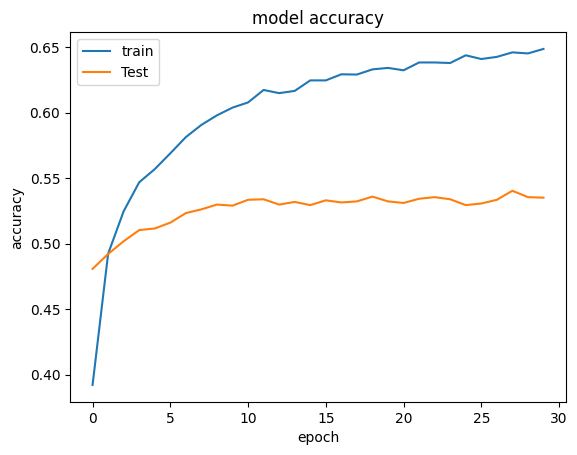

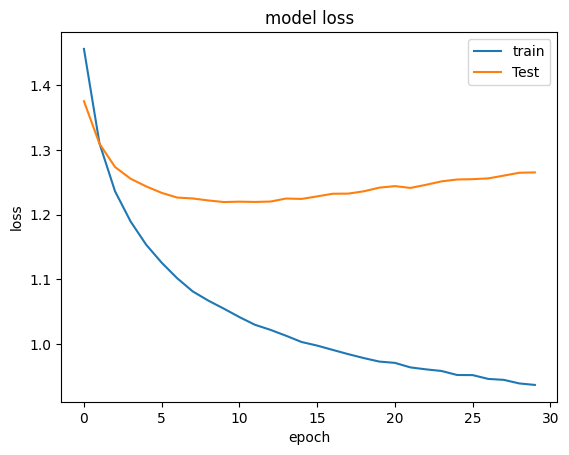

In [38]:
# Model Performance Chart

plt.plot(model_nn_history.history["acc"])
plt.plot(model_nn_history.history["val_acc"])

plt.title('model accuracy')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train","Test"])
plt.show()

plt.plot(model_nn_history.history["loss"])
plt.plot(model_nn_history.history["val_loss"])

plt.title('model loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","Test"])
plt.show()

## LSTM  Long Short-Term Memory 

In [39]:
lstm_model = keras.Sequential(
             [keras.layers.Embedding(vocab_length,50,weights=[embedding_matrix],input_length=max_len,trainable=False),
              keras.layers.LSTM(128),
              keras.layers.Dense(5,activation="softmax"),
             ])

In [40]:
opt = keras.optimizers.Adam(learning_rate=0.003)
lstm_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

In [41]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 50)            585450    
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 677,743
Trainable params: 92,293
Non-trainable params: 585,450
_________________________________________________________________


In [42]:
# Training 

lstm_model_history = lstm_model.fit(x_train,y_train,batch_size=128,epochs=30,validation_split=0.2)

Epoch 1/30
78/78 [==============================] - 6s 56ms/step - loss: 1.3876 - acc: 0.4292 - val_loss: 1.2426 - val_acc: 0.5294
Epoch 2/30
78/78 [==============================] - 4s 55ms/step - loss: 1.2125 - acc: 0.5301 - val_loss: 1.1308 - val_acc: 0.5623
Epoch 3/30
78/78 [==============================] - 4s 53ms/step - loss: 1.1392 - acc: 0.5533 - val_loss: 1.0877 - val_acc: 0.5659
Epoch 4/30
78/78 [==============================] - 4s 54ms/step - loss: 1.0543 - acc: 0.5779 - val_loss: 1.0623 - val_acc: 0.5736
Epoch 5/30
78/78 [==============================] - 4s 54ms/step - loss: 0.9551 - acc: 0.6279 - val_loss: 1.1112 - val_acc: 0.6219
Epoch 6/30
78/78 [==============================] - 4s 55ms/step - loss: 0.8650 - acc: 0.6715 - val_loss: 0.8506 - val_acc: 0.6832
Epoch 7/30
78/78 [==============================] - 4s 53ms/step - loss: 0.7408 - acc: 0.7328 - val_loss: 0.8144 - val_acc: 0.6905
Epoch 8/30
78/78 [==============================] - 4s 55ms/step - loss: 0.6545 - a

In [43]:
# Evaluation on Test Set

score = lstm_model.evaluate(x_test,y_test,verbose=1)

97/97 [==============================] - 1s 8ms/step - loss: 0.3559 - acc: 0.9062


In [44]:
print("Test Score :",score[0])
print("Test Accuracy :",score[1])

Test Score : 0.3558846116065979
Test Accuracy : 0.9061992764472961


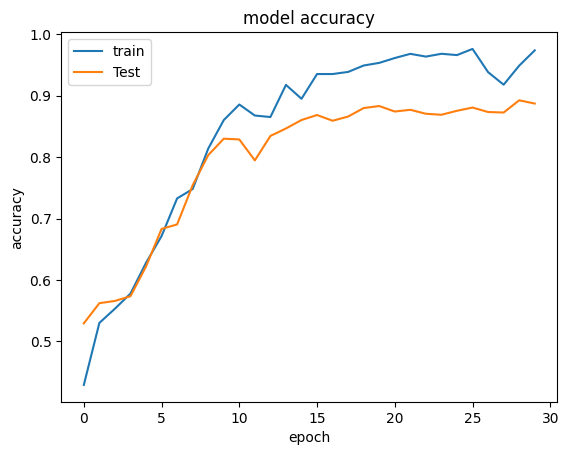

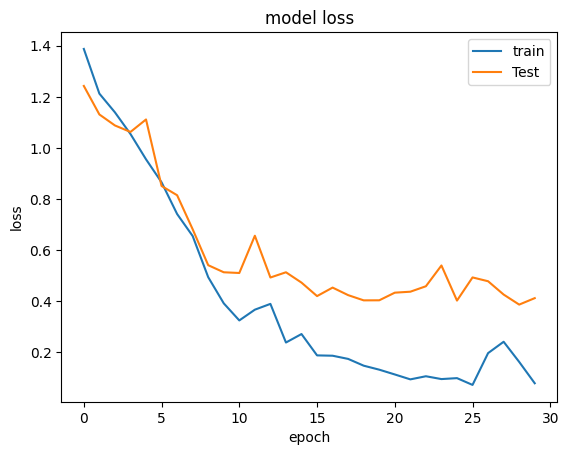

In [45]:
# Model Performance Chart

plt.plot(lstm_model_history.history["acc"])
plt.plot(lstm_model_history.history["val_acc"])

plt.title('model accuracy')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train","Test"])
plt.show()

plt.plot(lstm_model_history.history["loss"])
plt.plot(lstm_model_history.history["val_loss"])

plt.title('model loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","Test"])
plt.show()

In [46]:
lstm_model.save(f"./lstm_model.h5",save_format="h5")